In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [3]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [4]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'behavior', 'hand')

In [5]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [6]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 2), 'gaze_analysis', 'features')
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

In [7]:
MOUSE_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'mouse', 'compressed')

### Firstly, get the cleaned mouse data

In [8]:
MOUSE_CLEANED_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'mouse', 'cleaned')

In [9]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [10]:
from tqdm import tqdm

from utils.mouse_motion import (
    PHASE_OFFSETS, aggregate_stroke_events, stroke_detected_to_dicts
)

def save_all_cleaned_motions():
    for subj in tqdm(all_subjs):
        subj_f = f'{subj}.npz'
        subj_src_path = os.path.join(MOUSE_DATA_FOLDER, subj_f)
        subj_des_path = os.path.join(MOUSE_CLEANED_DATA_FOLDER, subj_f)
        if not os.path.exists(subj_des_path):
            subj_source_data = np.load(subj_src_path)
            strokes = aggregate_stroke_events(subj_source_data, PHASE_OFFSETS)
            stroke_dicts = stroke_detected_to_dicts(strokes)
            np.savez(subj_des_path, **stroke_dicts)

In [11]:
save_all_cleaned_motions()

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:06<00:00,  5.38it/s]


## load pair-up behavior and motion data

In [12]:
BEHAV_PATH = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'behavior', 'subjects')

def load_hand_motion_subj(subj):
    # load motion data
    subj_motion_path = os.path.join(
        MOUSE_CLEANED_DATA_FOLDER, f'{subj}.npz')
    subj_motion_data = np.load(subj_motion_path)
    # load df
    subj_df = pd.read_csv(
        os.path.join(BEHAV_PATH, f'{subj}.csv'),
        index_col=0)
    return subj_motion_data, subj_df


## Firstly, check the magnitude

In [13]:
from utils.eye_trial import generate_events

EVENTS = generate_events()

In [14]:
from utils.mouse_motion import compute_subj_motion_mags, T_TOTAL
from utils.eye_plotting import annotate_time_line
from scipy.ndimage import convolve1d

def collect_all_subjs_motion_mags(lmb, mag_normalize=True):
    collected = {}
    for subj in all_subjs:
        subj_motion_data, subj_df = load_hand_motion_subj(subj)
        subj_mags = compute_subj_motion_mags(
            subj_motion_data, subj_df, lmb, mag_normalize=mag_normalize)
        collected[subj] = subj_mags
    return collected


def plot_motion_mag_with_mask(ax, lmb, label=None, line_color='gray', mag_normalize=True, smooth_window=51):
    subj_mag_aggregated = collect_all_subjs_motion_mags(lmb, mag_normalize=mag_normalize)
    subj_mag_aggregated = [subj_mag_aggregated[k] for k in subj_mag_aggregated]
    subj_mag_aggregated = np.array(subj_mag_aggregated)

    # smoothing
    if smooth_window > 1:
        subj_mag_aggregated = convolve1d(
            subj_mag_aggregated, 
            np.ones(smooth_window)/smooth_window, 
            axis=1, mode='constant', cval=0.0)
            
    # plot it
    mean_mag = np.mean(subj_mag_aggregated, axis=0)
    sem_mag = np.std(subj_mag_aggregated, axis=0) / np.sqrt(len(subj_mag_aggregated))
    ax.plot(mean_mag, color=line_color, label=label)
    ax.fill_between(
        np.arange(T_TOTAL), 
        mean_mag-sem_mag, mean_mag+sem_mag, color=line_color, alpha=0.3)
    annotate_time_line(ax, EVENTS)

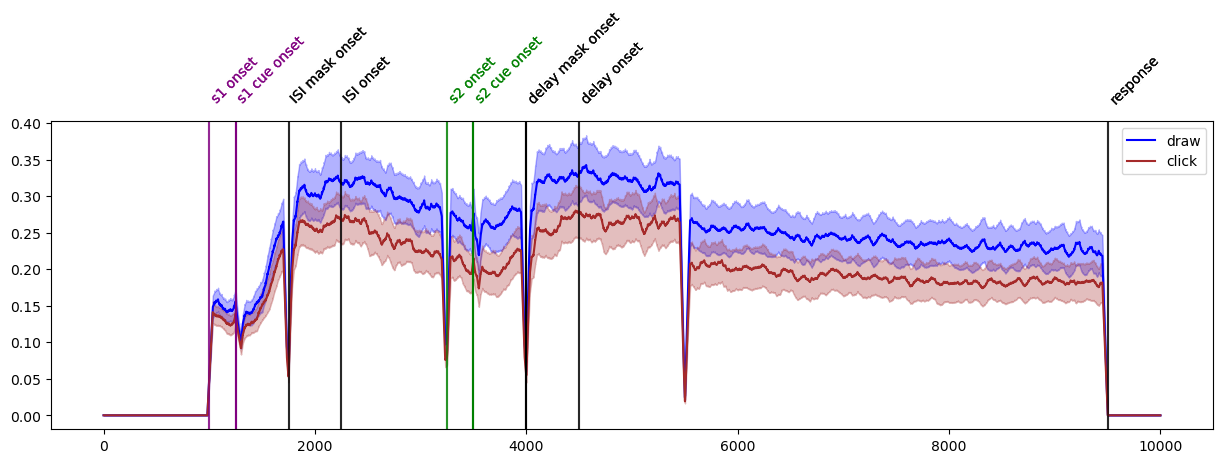

In [15]:
fig, ax = plt.subplots(1, figsize=(15, 4))
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
plot_motion_mag_with_mask(ax, draw_lmb, label='draw', line_color='blue', mag_normalize=False)
click_lmb = lambda d: (d['mode'] == 'click').to_numpy()
plot_motion_mag_with_mask(ax, click_lmb, label='click', line_color='brown', mag_normalize=False)
ax.legend()

plot_path = os.path.join(PLOTS_FOLDER, 'mode_hand_mag.png')
plt.savefig(plot_path)

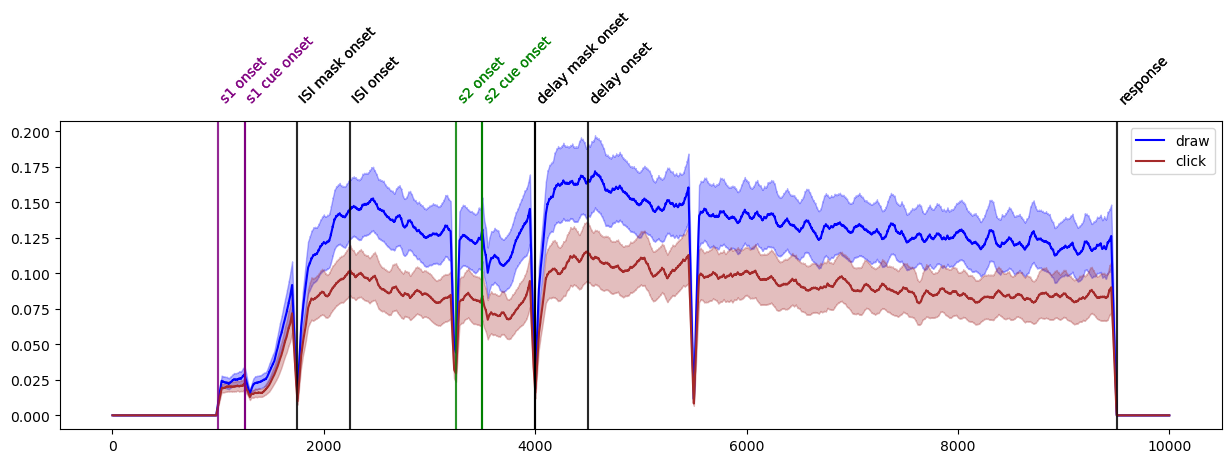

In [16]:
fig, ax = plt.subplots(1, figsize=(15, 4))
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
plot_motion_mag_with_mask(ax, draw_lmb, label='draw', line_color='blue', mag_normalize=True)
click_lmb = lambda d: (d['mode'] == 'click').to_numpy()
plot_motion_mag_with_mask(ax, click_lmb, label='click', line_color='brown', mag_normalize=True)
ax.legend()

plot_path = os.path.join(PLOTS_FOLDER, 'mode_hand_freq.png')
plt.savefig(plot_path)

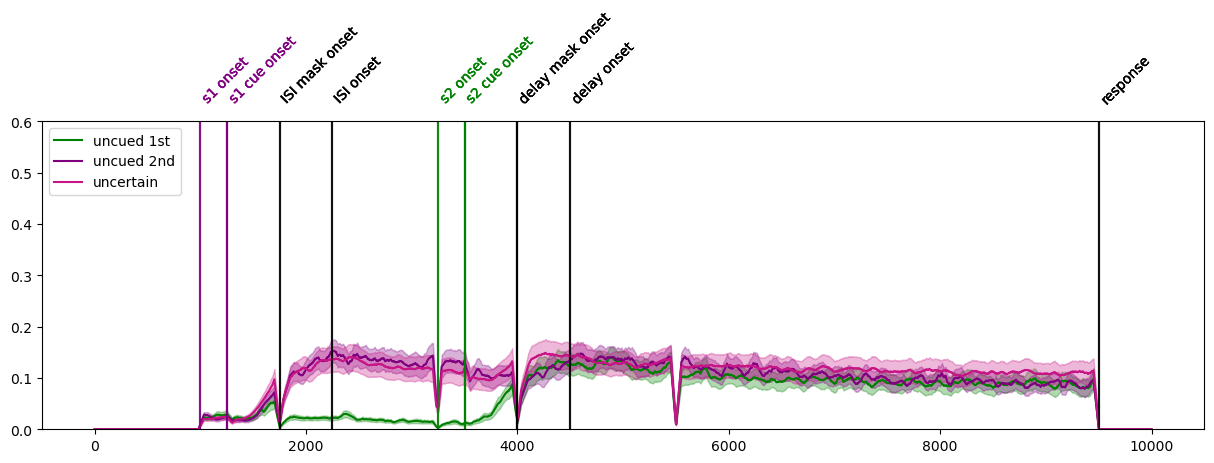

In [17]:
fig, ax = plt.subplots(1, figsize=(15, 4))
uncued_1st_lmb = lambda d: (
    (d['trial_code']==0) & (~(d['stim_1_to_report']))).to_numpy()
plot_motion_mag_with_mask(ax, uncued_1st_lmb, label='uncued 1st', line_color='green')
uncued_2nd_lmb = lambda d: (
    (d['trial_code']==0) & (~(d['stim_2_to_report']))).to_numpy()
plot_motion_mag_with_mask(ax, uncued_2nd_lmb, label='uncued 2nd', line_color='purple')
nullcue_lmb = lambda d: ((d['trial_code']==1)).to_numpy()
plot_motion_mag_with_mask(ax, nullcue_lmb, label='uncertain', line_color='mediumvioletred')
ax.set_ylim([0, 0.6])
ax.legend()

plot_path = os.path.join(PLOTS_FOLDER, 'stim1_hand_freq.png')
plt.savefig(plot_path)


## Check relevance: RSA or inverted encoding

In [18]:
from scipy.ndimage import gaussian_filter1d
from utils.mouse_motion import dicts_to_stroke_events, convert_cleaned_to_table

class HandAngleFeatureExtractor:
    def __init__(self, settings):
        self.settings = settings
        self.initialize()

    def initialize(self):
        pass

    def convert_subj_motion_data(self, subj_motion_data, N_trials, mag_normalize=False):
        # convert to angle and motions
        subj_events = dicts_to_stroke_events(subj_motion_data)
        subj_motions = convert_cleaned_to_table(
            subj_events, N_trials, T_TOTAL, mag_normalize=mag_normalize)
        subj_angles = subj_motions[..., 0]
        subj_mag = subj_motions[..., 1]
        return subj_angles, subj_mag

    def bin_data(self, data):
        time_bin = self.settings['time_binning']['timebin_size']
        # assuming the last dimension is time dimension
        shape_original = data.shape
        t_original = shape_original[-1]
        n_bins = t_original // time_bin
        data = data[..., :n_bins * time_bin]
        data = data.reshape(*shape_original[:-1], n_bins, time_bin)
        return data

    def angle_to_ids(self, angles):
        n_angle_bins = self.settings['angle_to_id']['n_angle_bins']
        to_fold = self.settings['angle_to_id']['to_fold']
        epoch = 180 if to_fold else 360
        angles = angles % epoch
        angle_bin_size = epoch / n_angle_bins 
        angle_bin_ids = (angles + angle_bin_size/2) / angle_bin_size
        angle_bin_ids = angle_bin_ids.astype(int) % n_angle_bins
        # print(angles[:2, :2, :3], angle_bin_ids[:2, :2, :3])
        return angle_bin_ids
    
    def batch_process_1dids(self, state_ids, weights):
        filter_zero = self.settings['occurence']['filter_zero']
        n_states = self.settings['angle_to_id']['n_angle_bins']
        
        assert len(state_ids.shape) == 3 
        n_trials, n_time_bins, timebin_size = state_ids.shape
        
        # compute number of occurence each trial, each time point
        occurences = None
        if filter_zero:
            occurences = np.sum(weights>0, axis=-1, keepdims=True)
        else:
            occurences = np.ones((n_trials, n_time_bins, 1)) * timebin_size

        # aggregate
        # output: n_trials * n_time_bins * n_states
        results = np.zeros((n_trials, n_time_bins, n_states))
        trial_indices, time_indices, state_indices = np.meshgrid(
            np.arange(n_trials), np.arange(n_time_bins), np.arange(timebin_size), indexing='ij'
        )
        np.add.at(
            results, 
            (trial_indices.ravel(), time_indices.ravel(), state_ids.ravel()), 
            weights.ravel())

        # normalize
        occ_non_zero = np.where(occurences>0, occurences, 1)
        results = results / occ_non_zero

        return results
    
    def convert_collapsed_1dvec(self, angles, mag_weights):
        # sum everything up
        angle_ids = self.angle_to_ids(angles)
        n_states = self.settings['angle_to_id']['n_angle_bins']
        h = np.zeros(n_states)
        np.add.at(h, angle_ids.flatten(), mag_weights.flatten())
        # normalization: count number of occurences
        filter_zero = self.settings['occurence']['filter_zero']
        n_occurences = np.sum(mag_weights > 0).astype(int) if filter_zero else np.size(xs)
        h = h / n_occurences

        return h
    
    def convert_eyedata_1dvec(self, angles, mag_weights):
        # aggreagte each time bin
        angles_binned = self.bin_data(angles)
        mag_weights_binned = self.bin_data(mag_weights)

        # convert angle to angle bin id
        angle_ids_binned = self.angle_to_ids(angles_binned)

        # now compute the collapsed
        results = self.batch_process_1dids(angle_ids_binned, mag_weights_binned)

        return results
        
    def get_subject_features(self, subj_motion_data, N_trials):
        # apply center normalization if needed  
        angles, mag_weights = self.convert_subj_motion_data(
            subj_motion_data, N_trials, mag_normalize=True)      
        
        # NOTE: input data should have been subject-normalized
        results = self.convert_eyedata_1dvec(angles, mag_weights)

        # also compute the subject bias, using the norm_phases
        subj_vec = self.convert_collapsed_1dvec(angles, mag_weights)
        
        # normalization: remove subject bias
        results = results - subj_vec

        # finally, apply smoothing
        smoothing_params = self.settings.get('smoothing')
        if smoothing_params is not None:
            results = gaussian_filter1d(
                results, 
                sigma=smoothing_params['sigma'], 
                mode='wrap', axis=-1)
        
        return results

In [19]:
# 1d
DEFAULT_1D_VEC_SETTINGS = {
    'occurence': {
        'filter_zero': True,
    },
    'angle_to_id': {
        'n_angle_bins': 30,
        'to_fold': False,
    },
    'time_binning': {
        'timebin_size': 50,
    },
    'dist_metric': 'cos',
    'smoothing': {
        'sigma': 2,
    }
}

In [20]:
feature_extractor = HandAngleFeatureExtractor(DEFAULT_1D_VEC_SETTINGS)

In [21]:
MOUSE_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'mouse', 'features')

def extract_subj_hand_1d_feature(subj):
    subj_feature_path = os.path.join(MOUSE_FEATURE_FOLDER, '1d', f'{subj}.npy')
    if not os.path.exists(subj_feature_path):
        # load data
        subj_motion_data, subj_df = load_hand_motion_subj(subj)
        N_trials = len(subj_df)
        subj_motion_features = feature_extractor.get_subject_features(
            subj_motion_data, N_trials)
        # save data
        np.save(subj_feature_path, subj_motion_features)

In [22]:
for subj in tqdm(all_subjs):
    extract_subj_hand_1d_feature(subj)

100%|██████████| 36/36 [00:01<00:00, 19.50it/s]


#### Read the outputs

In [23]:
def get_last_response(row):
    if pd.isna(row['resp_1_last_drawing_tend']) and pd.isna(row['resp_2_last_drawing_tend']):
        return np.nan
    elif pd.isna(row['resp_1_last_drawing_tend']):
        return row['resp_2']
    elif pd.isna(row['resp_2_last_drawing_tend']):
        return row['resp_1']
    else:
        return row['resp_2'] if row['resp_2_last_drawing_tend'] > row['resp_1_last_drawing_tend'] else row['resp_1']

def behav_df_add_last_response(df):
    df['current_last_response'] = df.apply(get_last_response, axis=1)
    df_copy = df[['participant', 'block', 'trial', 'current_last_response']].copy()
    df_copy['trial'] += 1  # Increment trial to match the next row's trial
    df_copy = df_copy.rename(columns={'current_last_response': 'prev_last_response'})
    df = df.merge(df_copy, on=['participant', 'block', 'trial'], how='left')
    return df

In [24]:
CLEANED_BEHAV_FOLDER_PATH = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'mouse', 'psychopy')

def read_padded_behav_df(subj):
    subj_behav_path = os.path.join(CLEANED_BEHAV_FOLDER_PATH, f'{subj}.csv')
    if not os.path.exists(subj_behav_path):
        src_df = pd.read_csv(
            os.path.join(BEHAV_PATH, f'{subj}.csv'), index_col=0)
        padded = behav_df_add_last_response(src_df)
        padded.to_csv(subj_behav_path, index=False)
    subj_df = pd.read_csv(subj_behav_path)
    return subj_df


In [25]:
def load_subject_time_feature(subj, time_steps, normalize=True):
    subj_feature_path = os.path.join(MOUSE_FEATURE_FOLDER, '1d', f'{subj}.npy')
    features = np.load(subj_feature_path)
    features = features[:, time_steps]
    features = np.mean(features, axis=1)

    if normalize:
        # normalize at the given time point
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)
        # clap to remove outlier
        clip_range = 5 
        features = np.clip(features, -clip_range, clip_range)
        # convert all to non-negative
        features = (features + clip_range) / (2 * clip_range)

    # also load the behavior data
    behavior_data = read_padded_behav_df(subj)

    return features, behavior_data

### Inverted Encoding

In [26]:
from utils.inverted_encoding import deg_signed_diff, ForwardModel

In [27]:
DEFAULT_FEATURE_CONVERSION = {
    # '0d': { 'old': np.array([0, 1]),},
    '1d': {
        'old': np.arange(0, 30),
        'zoom_ratio': 1.0,
    },
}

#### find the best sharpness

In [28]:
ISI_phase = np.arange(start=2500//50, stop=3000//50).astype(int) # 10 time points
delay_phase = np.arange(start=4750//50, stop=9250//50).astype(int)
delay_phases = np.split(delay_phase, 9) # 9 x 10 time points

In [29]:
sharpness_range = [0.5, 1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 30, 40]

In [30]:
from utils.inverted_encoding import raw_reformat_all_loaded

def reformat_all_loaded(phase, stim_names, cond_lmb):
    return raw_reformat_all_loaded(
        load_func=load_subject_time_feature,
        subjs=all_subjs,
        phase=phase, stim_names=stim_names, 
        cond_lmb=cond_lmb
    )

In [31]:
valid_1st_lmb = lambda df: ((df['stim_1_to_report']) | (df['trial_code'] == 1)).to_numpy()
ISI_xs, ISI_ys, _, _ = reformat_all_loaded(ISI_phase, ['stim_1'], valid_1st_lmb)

In [32]:
N_DEFAULT_CHANNELS = 18 # it seems yeild the best accuracy?

In [33]:
ISI_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=N_DEFAULT_CHANNELS)
ISI_best_sharpness, ISI_best_loss = ISI_forward_model.find_best_y_transform(
    ISI_xs, ISI_ys, item_weights=np.ones_like(ISI_ys), 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)
print(f'ISI best sharpness: {ISI_best_sharpness}, loss: {ISI_best_loss}')

sharpness 0.50 loss 0.383367 (invalid: 0.00)
sharpness 1.00 loss 0.383367 (invalid: 0.00)
sharpness 2.00 loss 0.383372 (invalid: 0.00)
sharpness 4.00 loss 0.383362 (invalid: 0.00)
sharpness 6.00 loss 0.383399 (invalid: 0.00)
sharpness 8.00 loss 0.383429 (invalid: 0.00)
sharpness 10.00 loss 0.383570 (invalid: 0.00)
sharpness 12.00 loss 0.383489 (invalid: 0.00)
sharpness 14.00 loss 0.383486 (invalid: 0.00)
sharpness 16.00 loss 0.383484 (invalid: 0.00)
sharpness 20.00 loss 0.383480 (invalid: 0.00)
sharpness 30.00 loss 0.383465 (invalid: 0.00)
sharpness 40.00 loss 0.383448 (invalid: 0.00)
ISI best sharpness: 4, loss: 0.38336232645833024


In [34]:
valid_both_lmb = lambda df: (
    (df['stim_1_to_report'] & df['stim_2_to_report']) | 
    (df['trial_code'] == 1)).to_numpy()

delay_xs, delay_ys, delay_dfs, _ = reformat_all_loaded(
    delay_phase, ['stim_1', 'stim_2'], valid_both_lmb)

In [35]:
from utils.inverted_encoding import convert_df_to_delay_design_matrix
item_weights_lmb = lambda df: convert_df_to_delay_design_matrix(df)

In [36]:
delay_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=N_DEFAULT_CHANNELS)
item_weights = item_weights_lmb(delay_dfs)
delay_best_sharpness, delay_best_loss = delay_forward_model.find_best_y_transform(
    delay_xs, delay_ys, item_weights=item_weights, 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)
print(f'Delay best sharpness: {delay_best_sharpness}, loss: {delay_best_loss}')

sharpness 0.50 loss 0.375295 (invalid: 0.00)
sharpness 1.00 loss 0.375295 (invalid: 0.00)
sharpness 2.00 loss 0.375291 (invalid: 0.00)
sharpness 4.00 loss 0.375268 (invalid: 0.00)
sharpness 6.00 loss 0.375330 (invalid: 0.00)
sharpness 8.00 loss 0.375258 (invalid: 0.00)
sharpness 10.00 loss 0.375252 (invalid: 0.00)
sharpness 12.00 loss 0.375237 (invalid: 0.00)
sharpness 14.00 loss 0.375237 (invalid: 0.00)
sharpness 16.00 loss 0.375237 (invalid: 0.00)
sharpness 20.00 loss 0.375236 (invalid: 0.00)
sharpness 30.00 loss 0.375235 (invalid: 0.00)
sharpness 40.00 loss 0.375237 (invalid: 0.00)
Delay best sharpness: 30, loss: 0.3752349117466676


#### Start training & testing

In [37]:
DEFAULT_FORWARD_MODEL_PARAMS = {
    'init': {
        'feature_conversion_params': DEFAULT_FEATURE_CONVERSION,
        'n_channels': N_DEFAULT_CHANNELS,
    },
    'forward': {
        'sharpness': delay_best_sharpness,
    }
}

In [38]:
delay_model = ForwardModel(**DEFAULT_FORWARD_MODEL_PARAMS['init'])

In [39]:
from utils.inverted_encoding import raw_across_subj_cross_phase_iterator

def across_subj_cross_phase_iterator(*args, **kwargs):
    return raw_across_subj_cross_phase_iterator(
        reformat_all_loaded,
        *args, **kwargs
    )

from utils.inverted_encoding import raw_cv_train_test_invert_encoding

def cv_train_test_invert_encoding(*args, **kwargs):
    return raw_cv_train_test_invert_encoding(
        across_subj_cross_phase_iterator,
        *args, **kwargs
    )

In [40]:
n_subjects = len(all_subjs)
full_delay_phase_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    # valid_both_lmb, valid_both_lmb, 
    None, None,
    item_weights_lmb, n_subjects)

Processing:   0%|          | 0/36 [00:00<?, ?it/s]

Processing: 100%|██████████| 36/36 [00:02<00:00, 15.36it/s]


In [41]:
DELAY_CHANNEL_PRED_MEAN = np.mean(full_delay_phase_results['preds'])
DELAY_CHANNEL_PRED_STD = np.std(full_delay_phase_results['preds'])
print(f'Delay channel prediction mean: {DELAY_CHANNEL_PRED_MEAN:.2f} std: {DELAY_CHANNEL_PRED_STD:.2f}')

Delay channel prediction mean: 0.06 std: 1.59


In [42]:
from utils.inverted_encoding import raw_channel_weights_to_pseudo_distrib

def channel_weights_to_pseudo_distrib(channel_weights, model, sharpness):
    return raw_channel_weights_to_pseudo_distrib(
       channel_weights, model, sharpness,
       delay_channel_pred_mean=DELAY_CHANNEL_PRED_MEAN,
       delay_channel_pred_std=DELAY_CHANNEL_PRED_STD
    )
    

In [43]:
from utils.inverted_encoding import raw_display_shifted_distrib

def display_shifted_distrib(*args, **kwargs):
    if 'ylim_min' not in kwargs:
        kwargs['ylim_min'] = 0.0040
    if 'ylim_max' not in kwargs:
        kwargs['ylim_max'] = 0.0075
    return raw_display_shifted_distrib(*args, **kwargs)

from utils.inverted_encoding import raw_display_stats_and_distrib

def display_stats_and_distrib(
        ax, # set to None to disable visualization
        results, stats_type, 
        common_lmb=None, condition_lmbs={}, item_weights_lmb=None, 
        sharpness=delay_best_sharpness, # sharpness to convert to distrib
        return_subj_stats=False # if to return each subject's stats
    ):
    return raw_display_stats_and_distrib(
        ax, results, stats_type, 
        common_lmb=common_lmb, condition_lmbs=condition_lmbs, 
        item_weights_lmb=item_weights_lmb,
        sharpness=sharpness, return_subj_stats=return_subj_stats,
        surrogate_model=delay_model,
        prediction_conversion_func=channel_weights_to_pseudo_distrib,
        display_shifted_distrib_func=display_shifted_distrib
    )

In [44]:
has_valid_prev_lmb = lambda df: ~(df['prev_last_response'].isna().values)
has_valid_prev_mask = has_valid_prev_lmb(full_delay_phase_results['test_df'])

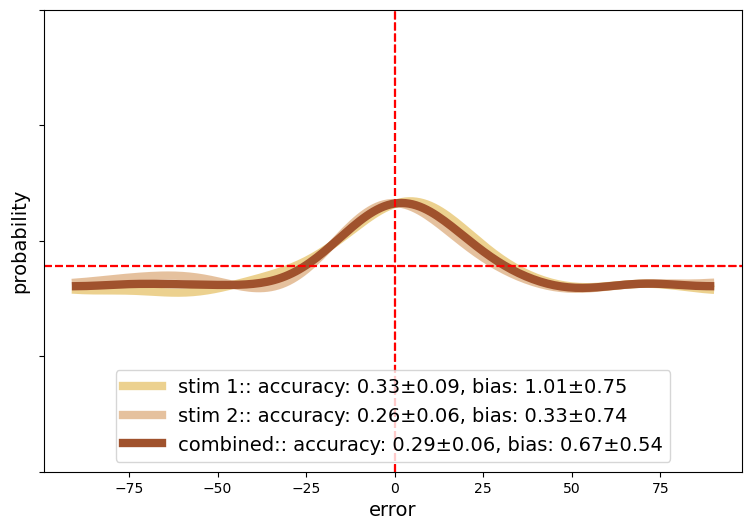

In [45]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=valid_both_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
# ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_delay.png')
plt.savefig(plot_path, bbox_inches='tight')


#### Compare Draw v.s. Click

In [46]:
draw_delay_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_delay_lmb = lambda df: (df['mode'] == 'click').to_numpy()
mode_lmbs = {
    'draw': draw_delay_lmb,
    'click': click_delay_lmb,
}

In [47]:
all_delay_across_modes = {}
item_weights_lmb = lambda df: convert_df_to_delay_design_matrix(df)
for train_mode in ['draw', 'click']:
    for test_mode in ['draw', 'click']:
        print(f'Trained on {train_mode}, tested on {test_mode}')
        n_subjects = len(all_subjs)
        train_lmb = mode_lmbs[train_mode]
        test_lmb = mode_lmbs[test_mode]
        modes_delay_phase_results = cv_train_test_invert_encoding(
            DEFAULT_FORWARD_MODEL_PARAMS, 
            delay_phase, delay_phase, 
            ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
            train_lmb, test_lmb, 
            item_weights_lmb, n_subjects)
        all_delay_across_modes[(train_mode, test_mode)] = modes_delay_phase_results

Trained on draw, tested on draw


Processing:   0%|          | 0/36 [00:00<?, ?it/s]

Processing: 100%|██████████| 36/36 [00:01<00:00, 23.08it/s]


Trained on draw, tested on click


Processing: 100%|██████████| 36/36 [00:01<00:00, 18.15it/s]


Trained on click, tested on draw


Processing: 100%|██████████| 36/36 [00:01<00:00, 22.58it/s]


Trained on click, tested on click


Processing: 100%|██████████| 36/36 [00:01<00:00, 21.65it/s]


In [48]:
mode_prev_lmbs = {
    'draw': lambda df: draw_lmb(df) & has_valid_prev_lmb(df),
    'click': lambda df: click_lmb(df) & has_valid_prev_lmb(df),
}

draw -> draw
draw -> click
click -> draw
click -> click


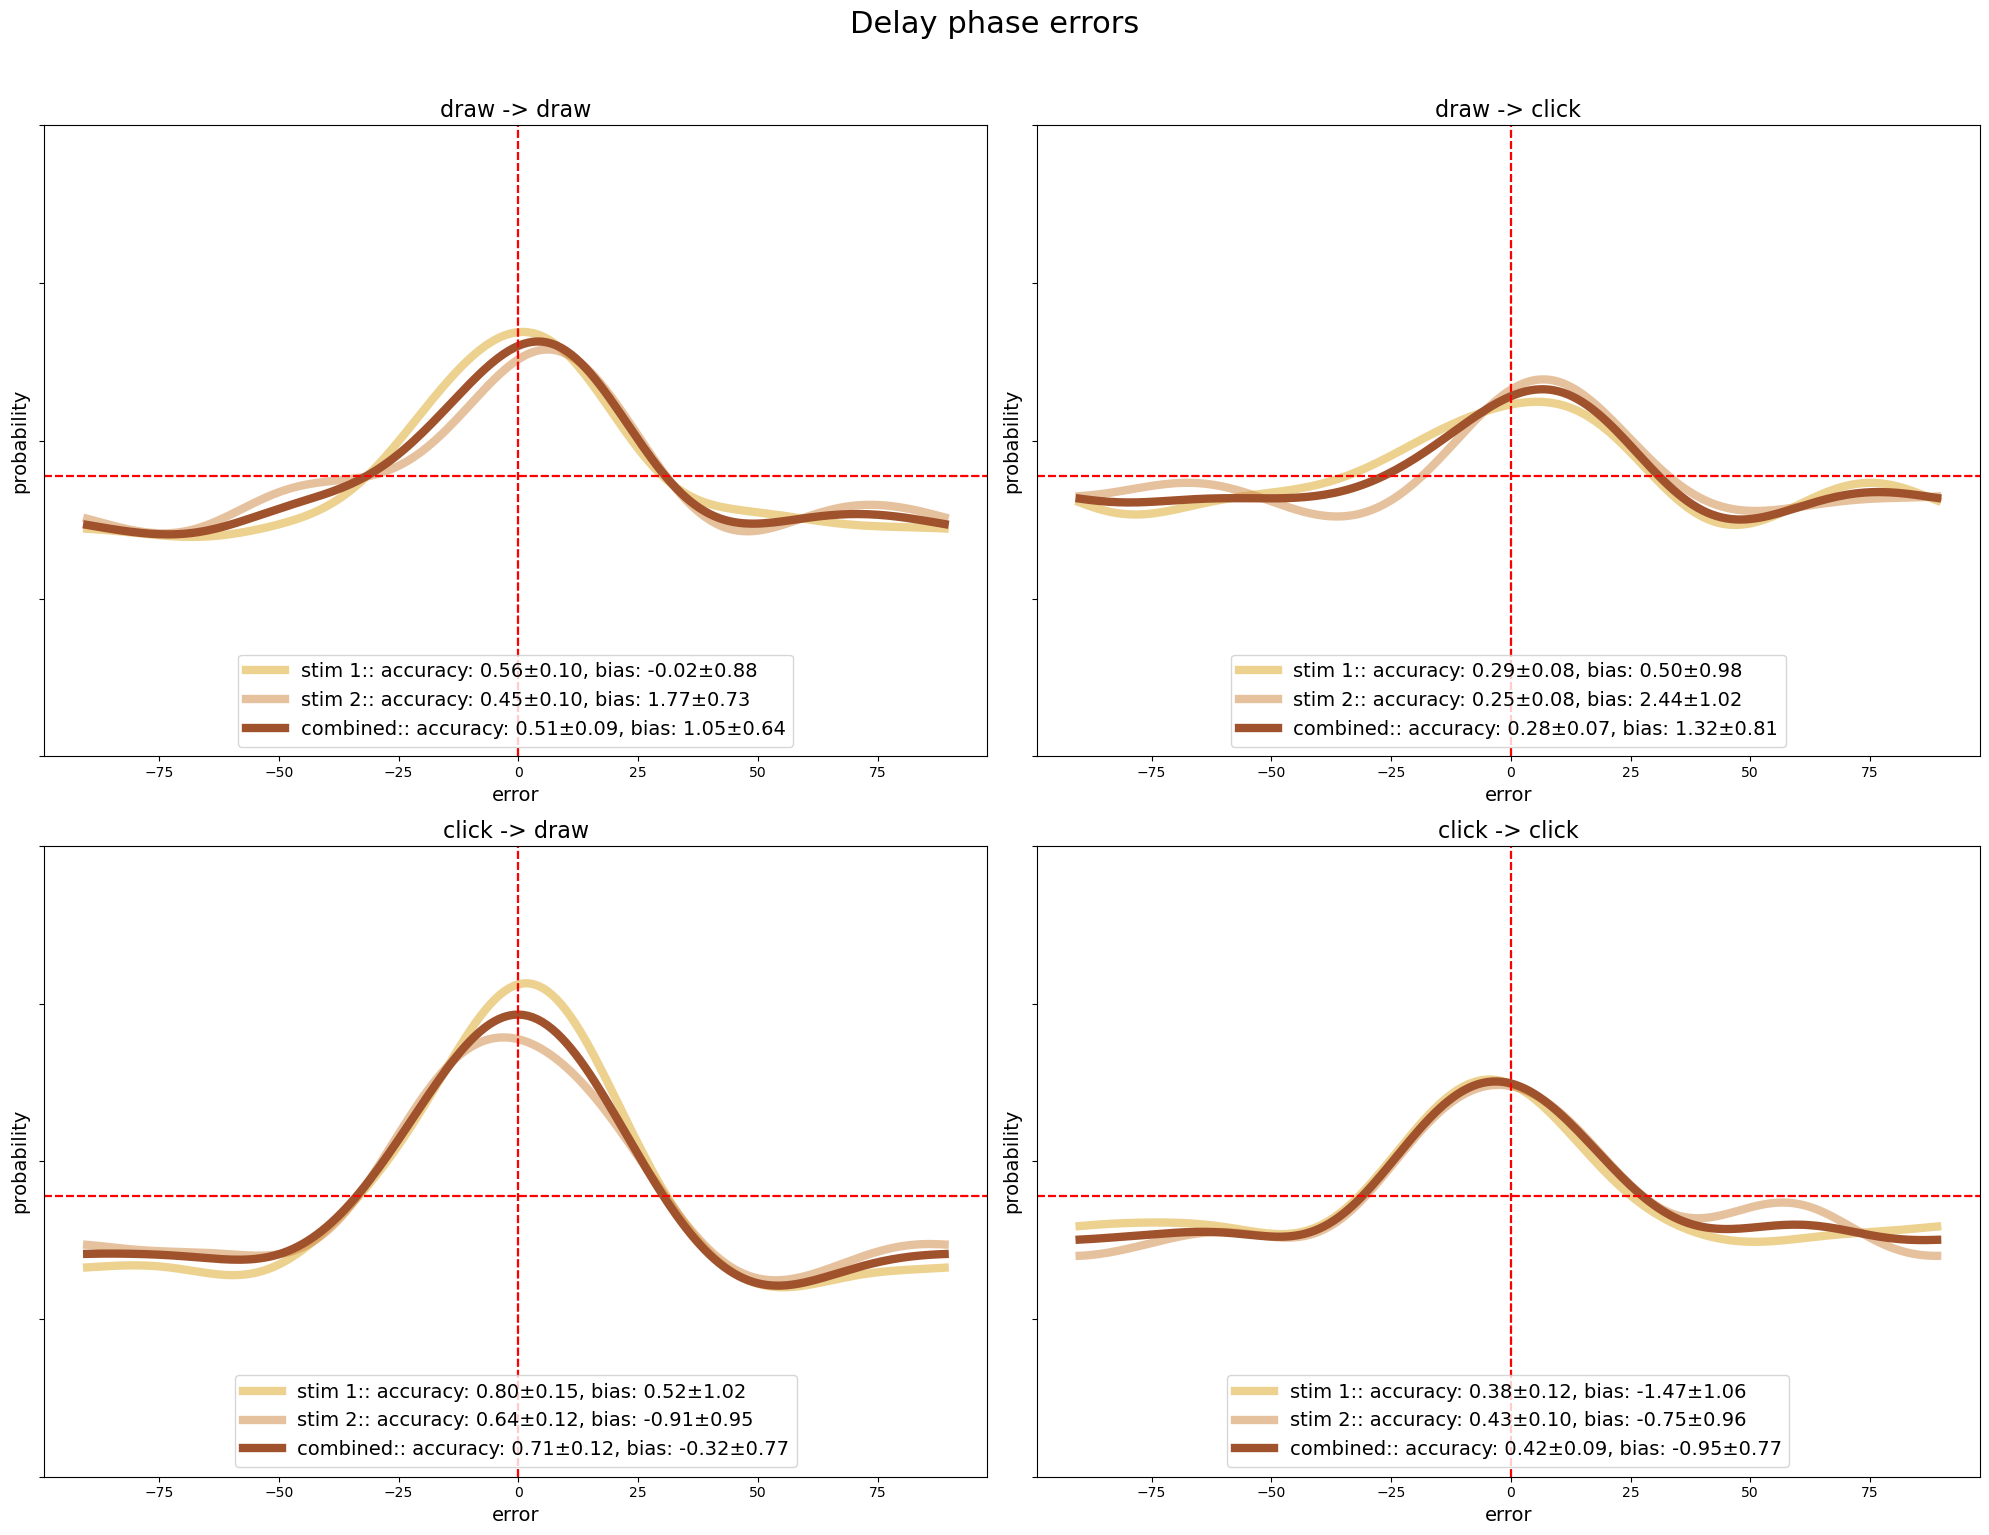

In [49]:
stim1_valid_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'])).to_numpy()
stim2_valid_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_2_to_report'])).to_numpy()

plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i, train_mode in enumerate(['draw', 'click']):
    for j, test_mode in enumerate(['draw', 'click']):
        print(f'{train_mode} -> {test_mode}')
        ax = axs[i, j]
        results = all_delay_across_modes[(train_mode, test_mode)]
        test_lmb = mode_lmbs[test_mode]
        display_stats_and_distrib(ax,
            results,
            stats_type='accuracy', 
            common_lmb=test_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb)
        ax.set_title(f'{train_mode} -> {test_mode}', fontsize=16)

plt.suptitle('Delay phase errors', fontsize=22, y=1.02)
plt.tight_layout()
plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_delay_modes.png')
plt.savefig(plot_path, bbox_inches='tight')

#### also check the encoding and ISI phase

In [50]:
from copy import deepcopy

DEFAULT_ISI_FORWARD_MODEL_PARAMS = deepcopy(DEFAULT_FORWARD_MODEL_PARAMS)
DEFAULT_ISI_FORWARD_MODEL_PARAMS['forward']['sharpness'] = ISI_best_sharpness

In [51]:
valid_isi_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'])).to_numpy()
isi_item_weights_lmb = lambda df: np.array([
    np.ones(len(df)),
    np.zeros(len(df)),
]).T
isi_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    ISI_phase, ISI_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

Processing:   0%|          | 0/36 [00:00<?, ?it/s]

Processing: 100%|██████████| 36/36 [00:02<00:00, 16.43it/s]


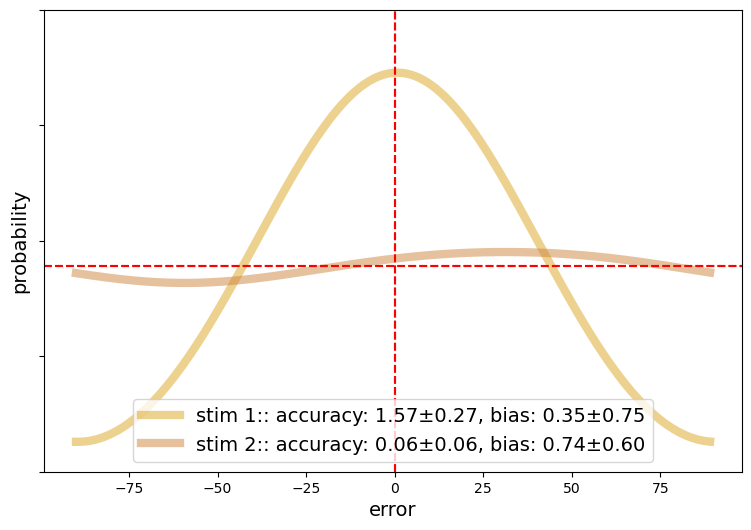

In [52]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

display_stats_and_distrib(ax,
    isi_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)

plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_isi.png')
plt.savefig(plot_path, bbox_inches='tight')

In [53]:
enc1_phase_after_cue = np.arange(start=1500//50, stop=1750//50).astype(int)

enc1_decode_results_after_cue = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, enc1_phase_after_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

Processing:   0%|          | 0/36 [00:00<?, ?it/s]

Processing: 100%|██████████| 36/36 [00:02<00:00, 17.30it/s]


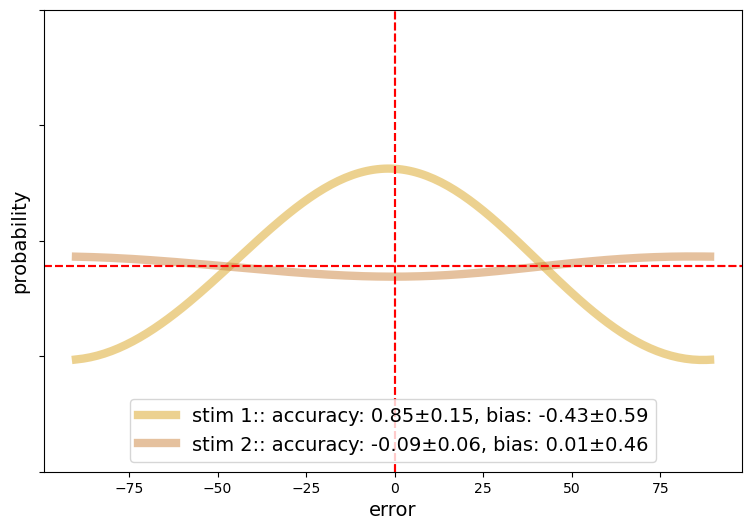

In [54]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

display_stats_and_distrib(ax,
    enc1_decode_results_after_cue,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)

plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_enc_after_cue.png')
plt.savefig(plot_path, bbox_inches='tight')

#### Serial Dependence?

In [55]:
from utils.inverted_encoding import generate_windows

DELAY_WINDOWS = generate_windows(delay_phase, 20, 7)
N_DELAY_WINDOW = len(DELAY_WINDOWS)
print(f'{N_DELAY_WINDOW} windows, each of {len(DELAY_WINDOWS[0])} time points')

11 windows, each of 20 time points


In [56]:
from utils.inverted_encoding import raw_within_across_phase_train_test

def within_across_phase_train_test(phases, train_test_lmb):
    return raw_within_across_phase_train_test(
        phases, train_test_lmb, 
        subjs=all_subjs,
        train_test_iterator=across_subj_cross_phase_iterator,
        model_params=DEFAULT_FORWARD_MODEL_PARAMS,
        item_weights_lmb=item_weights_lmb
    )

In [57]:
from utils.inverted_encoding import (
    raw_plot_single_stats_over_phase,
    raw_plot_stats_over_phase
)

def plot_single_stats_over_phase(
        ax, pred_results, stats_type, stat_name, phase_step,
        plot_settings, common_lmb, 
        plot_ymin=None, plot_ymax=None, label=None):

    return raw_plot_single_stats_over_phase(
        ax, pred_results, stats_type, stat_name, phase_step,
        plot_settings, common_lmb, 
        plot_ymin=plot_ymin, plot_ymax=plot_ymax, label=label,
        stats_computation_func=display_stats_and_distrib,
        item_weights_lmb=item_weights_lmb)

def plot_stats_over_phase(
        pred_results, stats_type, plot_settings, 
        common_lmb, plot_ymin=None, plot_ymax=None):
    return raw_plot_stats_over_phase(
        pred_results, stats_type, plot_settings,
        common_lmb, plot_ymin=plot_ymin, plot_ymax=plot_ymax,
        stats_computation_func=display_stats_and_distrib,
        item_weights_lmb=item_weights_lmb,
    )

In [58]:
mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, valid_both_lmb)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:41<00:00,  3.76s/it]


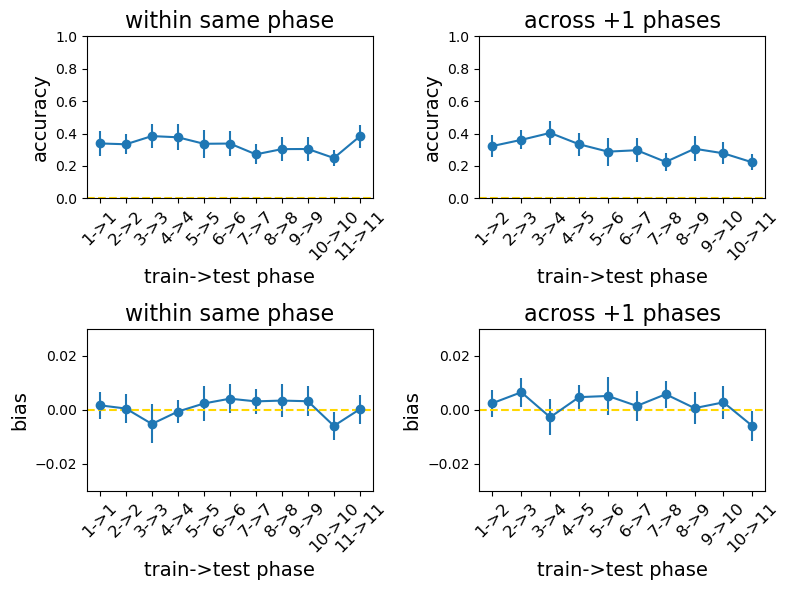

In [59]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem2_cross_phase_results, 'accuracy', 
    plot_settings, valid_both_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_delay_multi_phase_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [60]:
both_has_prev_lmb = lambda df: (has_valid_prev_lmb(df) & valid_both_lmb(df))

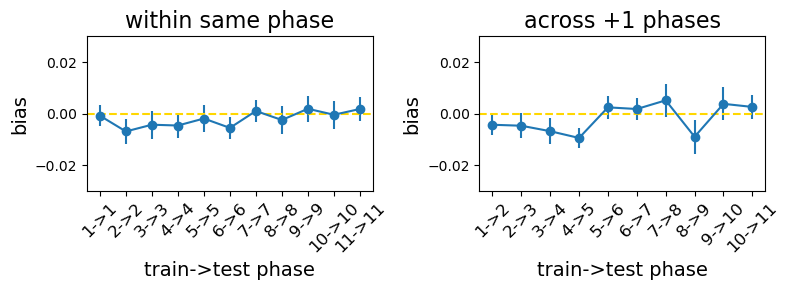

In [61]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem2_cross_phase_results, 'sd', 
    plot_settings, both_has_prev_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_delay_multi_phase_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

#### Collect the accuracy score

In [62]:
STATS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'stats', 'mouse', 'inverted_enc')

In [63]:
def store_subject_stats(results, common_lmb, condition_lmbs, stats_type, cond_name,
        item_weights_lmb=item_weights_lmb, sharpness=delay_best_sharpness):
    # collect subject level stats
    stats_results = display_stats_and_distrib(
        ax=None,
        results=results, 
        stats_type=stats_type, 
        common_lmb=common_lmb, 
        condition_lmbs=condition_lmbs, 
        item_weights_lmb=item_weights_lmb, 
        sharpness=sharpness,
        return_subj_stats=True # need subject wise stats
    )
    stats_results = stats_results[1] # fetch only subject level stats

    # store it
    sub_result_folder = os.path.join(STATS_FOLDER, f'{cond_name}')
    os.makedirs(sub_result_folder, exist_ok=True)
    result_path = os.path.join(sub_result_folder, f'{stats_type}.json')
    with open(result_path, 'w') as f: 
        json.dump(stats_results, f, indent=4)

In [64]:
draw_both_lmb = lambda d: (draw_lmb(d) & valid_both_lmb(d))

stats_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

store_subject_stats(
    results=all_delay_across_modes[('draw', 'draw')], 
    common_lmb=draw_both_lmb, condition_lmbs=stats_settings, 
    stats_type='accuracy', cond_name='draw',
    item_weights_lmb=item_weights_lmb, sharpness=delay_best_sharpness)

In [65]:
click_both_lmb = lambda d: (click_lmb(d) & valid_both_lmb(d))

store_subject_stats(
    results=all_delay_across_modes[('click', 'click')], 
    common_lmb=click_both_lmb, condition_lmbs=stats_settings, 
    stats_type='accuracy', cond_name='click',
    item_weights_lmb=item_weights_lmb, sharpness=delay_best_sharpness)

### RSA

In [66]:
from abc import ABC, abstractmethod
from utils.distrib import color_smart_diff, color_smart_diff_outer
from scipy.spatial.distance import cdist

smart_diff = lambda x1, x2: color_smart_diff(x1, x2, vmin=-90, vmax=90)
smart_diff_outer = lambda x1, x2: color_smart_diff_outer(x1, x2, vmin=-90, vmax=90)

class DistFunctions:
    """ define all distance function """
    @classmethod
    def diff(cls, x1, x2, dist_name, pairwise):
        if dist_name == 'cos':
            return cls.cos_diff(x1, x2, pairwise)
        elif dist_name == 'euc':
            return cls.euclidean_diff(x1, x2, pairwise)
        elif dist_name == 'deg':
            return cls.deg_diff(x1, x2, pairwise)
        elif dist_name == 'rad':
            return cls.rad_diff(x1, x2, pairwise)
        else:
            raise NotImplementedError(f'Unknown distance {dist_name}')

    @classmethod
    def cos_diff(cls, x1, x2, pairwise):
        x1 = x1 / np.linalg.norm(x1, axis=-1, keepdims=True)
        x2 = x2 / np.linalg.norm(x2, axis=-1, keepdims=True)
        if pairwise:
            dists = cdist(x1, x2, metric='cosine')
        else:
            similarity = np.sum(x1 * x2, axis=-1)
            dists = 1 - similarity
        return dists

    @classmethod
    def euclidean_diff(cls, x1, x2, pairwise):
        if pairwise:
            dists = cdist(x1, x2, metric='euclidean')
        else:
            diffs = x1 - x2
            dists = np.linalg.norm(diffs, axis=-1)
        return dists
    
    @classmethod
    def deg_diff(cls, x1, x2, pairwise):
        if pairwise:
            dists = smart_diff_outer(x1, x2)
        else:
            dists = smart_diff(x1, x2)
        dists = np.abs(dists)
        return dists
    
    @classmethod
    def rad_diff(cls, x1, x2, pairwise):
        dists = cls.deg_diff(x1, x2, pairwise)
        dists = np.deg2rad(dists)
        return dists

In [67]:
class FixedRepRSAHelper:
    def __init__(self, channels, channel_k):
        # to tackle sparsity we do fixed-effect RSA
        # all subjects are collated to form one pattern
        self.channels = np.arange(channels) * (180 // channels)
        self.channel_k = channel_k

    def compute_channel_pattern(self, neural_data, stims): 
        # compute their diff with channels
        # result: N x c
        data_channel_diff = DistFunctions.diff(
            stims, self.channel_resps, dist_name='deg', pairwise=True)
        selected_channel_ids = np.argmin(data_channel_diff, axis=1)

        # channel weights - N x n_channels
        data_channel_weights = np.zeros((len(neural_data), len(self.channels)))
        data_channel_weights[np.arange(len(neural_data)), selected_channel_ids] = 1

        # compute channel-wise pattern
        channel_patterns = data_channel_weights.T @ neural_data
        channel_weights = np.sum(data_channel_weights, axis=0)

        # normalize: (by weights)
        weight_safe = np.where(channel_weights == 0, 1, channel_weights)
        shape_expansion = [slice(None)] + [None] * (channel_patterns.ndim - 1)
        expanded_weights = weight_safe[tuple(shape_expansion)]  # Shape: c x ...
        normalized_channel_pattern = channel_patterns / expanded_weights

        return normalized_channel_pattern, channel_weights

    def compute_subj_correlation(self, subj_neural_data, subj_stims, pattern):
        n_trials = len(subj_neural_data)
        stim_diffs = DistFunctions.diff(
            subj_stims, self.channels, dist_name='rad', pairwise=True)
        pattern_diffs = DistFunctions.diff(
            subj_neural_data, pattern, dist_name='cos', pairwise=True)
        # compute the correlation
        all_corrs = []
        for trial_id in range(n_trials):
            corr = np.corrcoef(
                stim_diffs[trial_id], pattern_diffs[trial_id], rowvar=False)[0, 1:]
            all_corrs.append(corr)
        return all_corrs
    
    def compute_one_timepoint(self, subjs, timephase, lmb):
        raise NotImplementedError


    def compute_trial_n(self, neural_data, stim_rep, cur_trial_id, dist_method, valid_channel_w_thresh=0.1):        
        target_mask = np.zeros(len(neural_data)).astype(bool)
        target_mask[cur_trial_id] = True

        # get the target
        target_data = neural_data[target_mask]
        target_stim_rep = stim_rep[target_mask]

        # get the rest
        rest_data = neural_data[~target_mask]
        rest_stim_rep = stim_rep[~target_mask]

        # compute the pattern from the rest
        rest_channel_pattern, rest_channel_weights = self.compute_channel_pattern(rest_data, rest_stim_rep)

        # the diff between channel pattern and target pattern
        neural_diffs = DistFunctions.diff(
            rest_channel_pattern, target_data, 
            dist_name=dist_method, pairwise=False)

        # the diff between channel and target corresponding stims
        stim_diffs = DistFunctions.diff(
            self.channel_resps, target_stim_rep, 
            dist_name='cos', pairwise=False)

        # filter out missing channel?
        w_thresh = valid_channel_w_thresh * 1 / len(self.channels)
        valid_channel_mask = rest_channel_weights > w_thresh
        corr = np.nan
        if np.sum(valid_channel_mask) >= 2:
            # to compute correlation we need at least 2 data
            neural_diffs = neural_diffs[valid_channel_mask]
            stim_diffs = stim_diffs[valid_channel_mask]
            # compute the correlation
            corr = np.corrcoef(stim_diffs, neural_diffs, rowvar=False)[0, 1:]  # Shape: (T,)
        return corr

    def compute_one_subj_corr(self, neural_data, target, dist_method, valid_channel_w_thresh=0.0):
        valid_mask = ~np.isnan(target)
        neural_data = neural_data[valid_mask]
        target = target[valid_mask]

        n_trials = len(neural_data)

        corr_scores = []
        if n_trials <= 2:
            # we need at least 2 trials to compute correlation
            corr_scores = np.full(n_trials, np.nan)
        else:
            target_rep = self.rep_model.get_representation(target)

            for trial_id in range(n_trials):
                # print(trial_id)
                corr = self.compute_trial_n(
                    neural_data, target_rep, trial_id, dist_method,
                    valid_channel_w_thresh=valid_channel_w_thresh)
                corr_scores.append(corr)
            
            # compute the average
            corr_scores = np.array(corr_scores)

        return corr_scores
    
    def compute_all_subjs(self, all_subjs):
        # first compute the pattern
        all_subj_neural_data = []
        all_subj_dfs = []
        for subj in all_subjs:
            load_subject_time_feature()
